In [1]:
!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.3 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=050fdddd7ab483efe7a3164a9265857b750ee052f87df41591209a2dcccbaf83
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

Downloading the Huggingface dataset and storing it

In [2]:
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
!tar xf vocab.tar.gz

--2023-10-21 19:15:36--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz’

vocab.tar.gz        100%[===================>] 582.41K  --.-KB/s    in 0.1s    

2023-10-21 19:15:37 (5.49 MB/s) - ‘vocab.tar.gz’ saved [596389/596389]



Loading the textvqa dataset

In [4]:
with open("/content/vocabs/answers_textvqa_more_than_1.txt") as f:
  vocab = f.readlines()

answer_to_idx = {}
for idx, entry in enumerate(vocab):
  answer_to_idx[entry.strip("\n")] = idx
print(len(vocab))
print(vocab[:5])

from datasets import load_dataset
dataset = load_dataset("textvqa")

3997
['<unk>\n', 'nokia\n', 'ec\n', 'virgin\n', '2011\n']


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/34602 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5734 [00:00<?, ? examples/s]

Plotting an example image from the dataset

Question:  what year is shown in the photo?
Answers:  ['2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011']


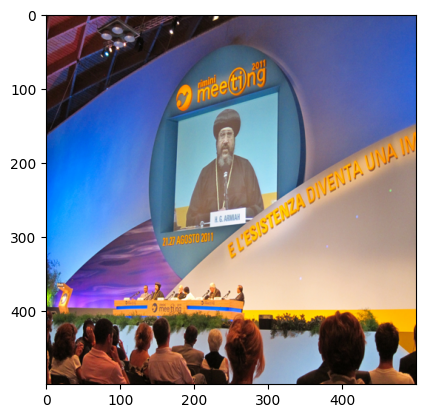

In [5]:
import matplotlib.pyplot as plt
import numpy as np
idx = 5
print("Question: ", dataset["train"][idx]["question"])
print("Answers: " ,dataset["train"][idx]["answers"])
im = np.asarray(dataset["train"][idx]["image"].resize((500,500)))
plt.imshow(im)
plt.show()

Converting the data -> Tensors and Pytorch compatible
1. Images -> TorchVision -> Tensors
2. Words -> BertTokenizer -> Tokens and (pad)

In [6]:
import torch
from torchvision import transforms
from collections import defaultdict
from transformers import BertTokenizer
from functools import partial

def transform(tokenizer, input):
  batch = {}
  image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([224,224])])
  image = image_transform(input["image"][0].convert("RGB"))
  batch["image"] = [image]

  tokenized=tokenizer(input["question"],return_tensors='pt',padding="max_length",max_length=512)
  batch.update(tokenized)


  ans_to_count = defaultdict(int)
  for ans in input["answers"][0]:
    ans_to_count[ans] += 1
  max_value = max(ans_to_count, key=ans_to_count.get)
  ans_idx = answer_to_idx.get(max_value,0)
  batch["answers"] = torch.as_tensor([ans_idx])
  return batch

tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",padding="max_length",max_length=512)
transform=partial(transform,tokenizer)
dataset.set_transform(transform)

Importing the FLAVA Checkpoint and the classification head

In [7]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(num_classes=len(vocab))

flava_for_pretraining_unified_text_encoder.pt: 1.43GB [00:38, 36.9MB/s]                            


A simple iteration with training loop

In [8]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size= BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())


epochs = 1
for _ in range(epochs):
  for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])
    loss = out.loss
    loss.backward()
    optimizer.step()
    print(f"Loss at step {idx} = {loss}")
    if idx >= MAX_STEPS-1:
      break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss at step 0 = 8.255939483642578
Loss at step 1 = 8.333304405212402
Loss at step 2 = 8.292935371398926
